# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
assert(len(X_train) == len(y_train))

n_train = len(X_train)


# TODO: Number of testing examples.
assert(len(X_test) == len(y_test))
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape
assert(image_shape[0] == image_shape[1])
img_dim = image_shape[0]   # should be 32, same as height (i.e. shape[1])
img_depth = image_shape[2] # should be 3...

# TODO: How many unique classes/labels there are in the dataset.

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_train)
print("Number of testing examples =", n_test)

print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of validation examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Choosing a random number up to  39209
Random index:  16424
Class:  10


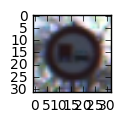

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print("Choosing a random number up to ", n_train)
index = random.randint(0, n_train)
print("Random index: ", index)

image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print("Class: ", y_train[index])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
import cv2

######################## Augment the training dataset #########################
# Sharpening kernels (see Book of OpenCV for python with examples)
kernel1 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
kernel2 = np.array([[1,1,1], [1,-7,1], [1,1,1]])
kernel3 = np.array([[-1,-1,-1,-1,-1],
                    [-1,2,2,2,-1],
                    [-1,2,8,2,-1],
                    [-1,2,2,2,-1],
                    [-1,-1,-1,-1,-1]]) / 8.0

# apply a filter to an image
def sharpenImage(img, kernel):
    return cv2.filter2D(img, -1, kernel)

# this function increases constrast of a 3_channel pixel
# by multiplying the respective values and bounding them at 255
def mulRGBChannels(pixel, s):
    ch1xs = s * pixel[0]
    ch2xs = s * pixel[1]
    ch3xs = s * pixel[2]
    newpixel = [0, 0, 0]
    if (ch1xs > 255):    
        newpixel[0] = 255
    else:
        newpixel[0] = np.uint8(ch1xs)
    if (ch2xs > 255):    
        newpixel[1] = 255
    else:
        newpixel[1] = np.uint8(ch2xs)
    if (ch3xs > 255):    
        newpixel[2] = 255
    else:
        newpixel[2] = np.uint8(ch3xs)
    
    return newpixel

# This function distorts an image
# by applying a skewed coordinate system 
# in an affine transformation
def warpImageWithSkewedAxes(img, theta):
    
    dim = img.shape[0]     
    assert(dim == img.shape[1])    
    
    
    M = np.float32([[np.cos(theta), np.sin(theta), 0], 
                    [np.sin(theta), np.cos(theta), 0]])
    
    return cv2.warpAffine( img, M, (dim, dim) ) 


            
# This function augments the data by generating synthetic images
# with doubled brightness and some amount of affine distortion
def augmentTrainingData(X_train, y_train, p = 0.1):
    
    dim = X_train.shape[1]    
    assert(dim == X_train.shape[2])
    num_train = len(X_train)
    # going through the training data
    new_train_input_list = []  
    new_train_output_list = []
    demo_list = [] # 3 illustrations of what the additional images look like
    for i in range(num_train):
        # progress indicator..
        if (i % 1000 == 0) or (i == num_train-1):
            print("{:.3f}".format( i*1.0 / (num_train - 1) * 100.0 ), " % completed.")
        # augmenting with uniform probablity p
        img = X_train[i].squeeze() # it doesnt hurt to squeeze,
                                  # although probably not necessary
        # sharpening the image
        img_sharp = sharpenImage(img, kernel3)
        # adding the image and its sharpened version and the respective output(s)
        new_train_input_list.append(img)
        new_train_input_list.append(img_sharp)
        for j in range(2):
            new_train_output_list.append(y_train[i])
        
        # randomly choosing an image to create 
        # synthetic slightly altered versions of it        
        if (np.random.uniform() < p): 
            # 1. Now emulating some projective distortion
            # by warping the image with slightly skewed axes
            theta = -8 * np.pi / 180
            img_sk_5 = warpImageWithSkewedAxes(img, theta)
            img_sk_5_sharp = warpImageWithSkewedAxes(img_sharp, theta)
            
            theta = 8 * np.pi / 180
            img_sk5 = warpImageWithSkewedAxes(img, theta)
            img_sk5_sharp = warpImageWithSkewedAxes(img_sharp, theta)
            
            # 2. Increasing constrast by x2 (deprecated)
            
            # (img, img_sk_5 and img_sk5)
            #img_x2 = np.zeros(img.shape, np.uint8)
            #img_sk_5x2 = np.zeros(img.shape, np.uint8)
            #img_sk5x2 = np.zeros(img.shape, np.uint8)
                        
            #for r in range(dim):
            #    for c in range(dim):
            #        img_x2[r][c] = mulRGBChannels(img[r][c], 2)   
            #        img_x2[r][c] = mulRGBChannels(img[r][c], 2)
            #        img_sk_5x2[r][c] = mulRGBChannels(img_sk_5[r][c], 2)
            #        img_sk5x2[r][c] = mulRGBChannels(img_sk5[r][c], 2)
            
            # note here that OpenCV zero-pads by default the parts of the 
            # new image that dont get a value from the original.
            # I am guessing that's a good thing (as opposed to large values) 
            # because (0, 0, 0) will be multiplied with weights that are
            # anyway very small on marginal pixels (they should be irrelevant).
            
            # Ok, we have got the extra images. Add them to the list!
            #new_train_input_list.append(img_x2)
            new_train_input_list.append(img_sk_5)
            new_train_input_list.append(img_sk5)
            
            #new_train_input_list.append(img_sk_5x2)
            #new_train_input_list.append(img_sk5x2)
            new_train_input_list.append(img_sk_5_sharp)
            new_train_input_list.append(img_sk5_sharp)
            
            
            # and the respective outputs...
            for j in range(4):
                new_train_output_list.append(y_train[i])
            
            if (len(demo_list) < 3):
                # omitting the obtuse and oblique equalized images for display reasons
                demo_list.append([img, img_sharp, img_sk_5, img_sk5, img_sk_5_sharp, img_sk5_sharp])
    # That's it! Returns the new data
    return np.array(new_train_input_list), np.array(new_train_output_list), demo_list           


In [5]:
# Just a function to demonstrate how synthetic images are produced
def syntheticImageIllustration(images):
    fig = plt.figure()
    a = fig.add_subplot(1, 6, 1)
    plt.imshow(images[0])
    a.set_xlabel("Original", fontsize = 8)
    
    
    b = fig.add_subplot(1, 6, 2)
    plt.imshow(images[1])
    b.set_xlabel("Sharpened", fontsize = 8)
    
    
    c = fig.add_subplot(1, 6, 3)
    plt.imshow(images[2])
    c.set_xlabel("Oblique ", fontsize = 8)
        
    d = fig.add_subplot(1, 6, 4)
    plt.imshow(images[3])
    d.set_xlabel("Obtuse", fontsize = 8)
    
    e = fig.add_subplot(1, 6, 5)
    plt.imshow(images[4])
    e.set_xlabel("Oblique sharp", fontsize = 8)
    
    f = fig.add_subplot(1, 6, 6)
    plt.imshow(images[5])
    f.set_xlabel("Obtuse sharp", fontsize = 8)

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# 1. Separate the validation set PRIOR to augmentation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

# updating length variables (just in case we need them below and to avoid confusion)
n_validation = len(X_validation)
n_train = len(X_train)

# 2. Handle a training image with probability 0.40 
X_train, y_train, demo_images = augmentTrainingData(X_train, y_train, p = 0.3) 

# 2. Shuffle the training data
X_train, y_train = shuffle(X_train, y_train)
n_train = len(X_train)
print("New size of training data: ", n_train)



0.000  % completed.
3.188  % completed.
6.376  % completed.
9.564  % completed.
12.753  % completed.
15.941  % completed.
19.129  % completed.
22.317  % completed.
25.505  % completed.
28.693  % completed.
31.882  % completed.
35.070  % completed.
38.258  % completed.
41.446  % completed.
44.634  % completed.
47.822  % completed.
51.011  % completed.
54.199  % completed.
57.387  % completed.
60.575  % completed.
63.763  % completed.
66.951  % completed.
70.140  % completed.
73.328  % completed.
76.516  % completed.
79.704  % completed.
82.892  % completed.
86.080  % completed.
89.269  % completed.
92.457  % completed.
95.645  % completed.
98.833  % completed.
100.000  % completed.
New size of training data:  100414


In [7]:
## Samples of synthetic images 

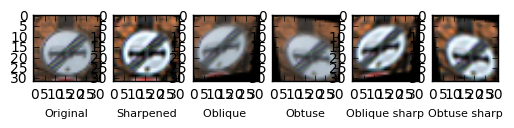

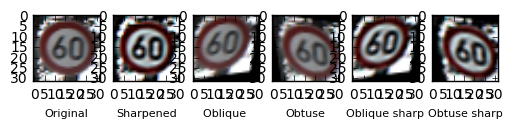

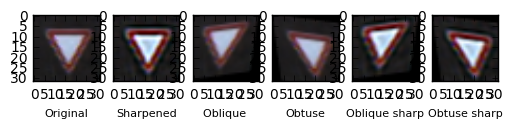

In [8]:

for j in range(len(demo_images)):
    syntheticImageIllustration(demo_images[j])

In [9]:
## Do rough standardization (subtract 128 and then divide by 128)

In [10]:

X_train1 = np.float32(X_train) - 128.0
X_train1 = X_train1 / 128.0
X_validation1 = np.float32(X_validation) - 128.0
X_validation1 = X_validation1 / 128.0
X_test1 = np.float32(X_test) - 128.0
X_test1 = X_test1 / 128.0


### Question 1 
_Describe how you preprocessed the data. Why did you choose that technique?_




**Answer:**

#### 1. The usual shuffle
Besides the typical shuffling to avoid long sequences of similar images in the training set, I have generated additional input images from the initial data.
#### 2. Standardization
I found that stardardizing the data (i.e., subtract by a "global mean" of 128 and then divide by a "global standard deviation" of  128) gives better results on both validation and test set. Furthermore, it promotes faster convergence.
#### 3. Additional data 
   From a quick initial execution of the LeNet with slightly hiked-up parameters  (e.g., 8 instead of 6 outputs in the first convolution layer, 18 instead of 16 outputs in the second, and so on...) showed that the data fit the validation data relatively well, but the network drops its performance by a good 7-8 % on the test set. This means that a LeNet variant can probably do the classification job well in the case of traffic-signs, but it also means that the netrwork will overfit easily if the data is not sufficiently big in numbers. So, more data is probably a good idea. 
   Furthermore, from multiple examples in the German dataset, it appears that many images are blurred and indistinguishable to the human eye (which empirically suggests less confident gradient features for the deep network). With minor effort, they could be used to produce sharper images (larger gradient values) which could force the network to become more "confident" about the gradient patterns of these images.
   I decided to use the existing data in producing additional synthetic images which would be different than the originals in sharpness and affine scaling (to emulate perspective distortion as if the sign was observed from slightly different angles). The dataset is augmented by sharpening the images sequentially and randomly choosing candidates (probability p) to add affine distortion. I observed that for p >= 0.3, the network (almost) always gives validation performance above or equal 99.0% within 20 epochs of training. The small, stochastic variations in training accuracy tend to affect performance by 0.1-0.5% in the test set with more-less similar percentages in the external sign images.
   
#### Data boosting vs Overfitting: Notes on performance evaluation

It is clear that the network overfits to a certain extent (not horribly, but it does). The reason is also clear: The dataset is just small for this sort of task. If the dataset is fully augmented (i.e. p = 1), then the softmax distributions in the additional images becomes extremely confident albeit not entirely correct (with an accuracy up to 92%). In other words, the outputs are also very confident even when they are mistaken. This means overfitting. Reason being the new data are synthetic and in some sense they are repetitions of the original.

There are two ways to evaluate the network - preferred is (a):

##### a) Boost the data with small probability p = 0.3 to avoid overfitting:
   In this case, the softmax distributions are less confident, but this allows flexibility with images that are hard to classify. On the other hand, due to stochasticity, test performance may vary by a (very) small percentage from one training run to another, but in overall it is in the ball-park of 93.5%. The gain however is the "versatility" of the softmax distributions. 

##### b) Boost the data with high probability p = 0.99.
   In this case the training output, although Adam is stochastic, will be more-less the same from one training sweap to another. The softmax distributions generally look like impulses, even if their faith is clearly "misplaced".   
   
#### NOTE: Choice of p
I would recommend trying data boosting with p = 0.3 (current setting), 0.4, or 0.5. It trains fast and overfitting is generally avoided. 
  



### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

The validation data is simply a randomly chosen chunk of the ORIGINAL training data. This means that the training data boosting with synthetic images is applied ONLY on the chosen training set and AFTER the separation into training and validation.

Following the addition of synthetic training data, all three datasets (training, validation, test) are standardized (i.e., subtract 128 from all channels and then divide by 128).

Each image in the original dataset produces 1+4 new images as follows:

a. Sharpened version: With a simple sharpening kernel (see "openCV with Python by Example" book) a sharpened version of each image in the dataset is created and added to the new dataset.

b. Distorted version by an oblique coordinate systems is as follows:
   The transformation
                       M = [ cos(theta), sin(theta), 0;  sin(theta), cos(theta), 0]
   is applied to image with theta = 8 (degrees). This creates a somewhat "oblique" 
   version of the image.

c. Sharpened oblique image: Just apply the sharpening filter on the image of (b).

d. Distorted version by an obtuse coorinate system by applyin the transformation of (b) with theta = -8 (degrees).

e. Sharpened version of the image of (d).

#### NOTE: The affinely distorted versions of an original training image are added to augmented training set the with a probability p (suggested 0.3, but higher values can be used with equal or better results - training will be much slower though...)

In [11]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 20 # The optimizer should reach a >99% validation performance at least once 
#EPOCHS = 4
BATCH_SIZE = 256
initialRate = 0.001

def TrafficSign_Net(x):    
        # Hyperparameters
    mu = 0
    sigma = 0.1 
    
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x8.
    l1_weights = tf.Variable( tf.truncated_normal([5, 5, 3, 8], mu, sigma) ) 
    l1_biases = tf.Variable( tf.zeros(8) )
    
    l1_conv = tf.nn.conv2d(x, l1_weights, strides=[1, 1, 1, 1], padding='VALID')
    l1_conv = tf.nn.bias_add(l1_conv, l1_biases)
    
    
    # Activation.
    l1_activation = tf.nn.relu(l1_conv)
    
    # Pooling. Input = 28x28x8. Output = 14x14x8.
    l1_pool = tf.nn.max_pool( l1_activation, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')    
    
    # Layer 2: Convolutional. Output = 10x10x18.
    l2_weights = tf.Variable( tf.truncated_normal([5, 5, 8, 18], mu, sigma) ) 
    l2_biases = tf.Variable( tf.zeros(18) )
    l2_conv = tf.nn.conv2d(l1_pool, l2_weights, strides=[1, 1, 1, 1], padding='VALID')
    l2_conv = tf.nn.bias_add(l2_conv, l2_biases)
    
    # Layer #2 Activation.
    l2_activation = tf.nn.relu(l2_conv)
    
    # Pooling. Input = 10x10x18. Output = 5x5x18.
    l2_pool = tf.nn.max_pool( l2_activation, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID') 
    #l2_pool = tf.nn.avg_pool(l2_activation, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 5x5x18. Output = 450.
    fc1 = flatten(l2_pool)
    
    # Layer 3: Fully Connected. Input = 450. Output = 200.
    l3_weights = tf.Variable(tf.truncated_normal([450, 200], mu, sigma))
    l3_biases = tf.Variable( tf.zeros(200) )
    l3_linear = tf.matmul(fc1, l3_weights) + l3_biases
    l3_activation = tf.nn.relu(l3_linear)
    #l3_activation = tf.nn.sigmoid(l3_linear)
    
    
    # Layer 4: Fully Connected. Input = 300. Output = 120.
    l4_weights = tf.Variable(tf.truncated_normal([200, 120], mu, sigma))
    l4_biases = tf.Variable( tf.zeros(120) )
    l4_linear = tf.matmul(l3_linear, l4_weights) + l4_biases
    #l4_activation = tf.nn.softplus(l4_linear)
    l4_activation = tf.nn.relu(l4_linear)
    #l4_activation = tf.nn.sigmoid(l4_linear)
    
    # Layer 5: Fully Connected. Input = 120. Output = 90.
    l5_weights = tf.Variable(tf.truncated_normal([120, 90], mu, sigma))
    l5_biases = tf.Variable( tf.zeros(90) )
    l5_linear = tf.matmul(l4_activation, l5_weights) + l5_biases
    #l5_activation = tf.nn.relu(l5_linear)
    l5_activation = tf.nn.sigmoid(l5_linear)
    
    # Layer 6: Fully Connected. Input = 90. Output = 43 (n_classes).
    l6_weights = tf.Variable( tf.truncated_normal([90, n_classes], mu, sigma) )
    l6_biases = tf.Variable( tf.zeros(n_classes) )
    l6_linear = tf.add(tf.matmul( l5_activation, l6_weights), l6_biases )
    
    logits = l6_linear
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The network is a LeNet variant with an additional layer in the fully connected region and slightly more parameters in the outputs of each layer (which by virtue of the knock-on effect causes larger inputs in subsequent layers). Furthermore, the penultimate layer (i.e., the 5th layer in the present architecture) produces a sigmoid output instead of a rectified linear (I observed better performance with the sigmoid in the fully connected region, possibly because it offers finer detail for below-zero values which may carry significant information for discrimination).

In particular:

#### Layer #1

Convolutional: Input = 32x32x3. Output = 5x5x8 (max-pooled).
                
1.a. Rectified linear activation 
1.b. Pooling with Output = 14x14x8.

#### Layer #2

Convolutional: Input = 14x14x8.   Output = 450 (flat).

2.a. Rectified linear activation.
2.b. Pooling with output = 5x5x18
2.c. Single vector (flat) output: 450

#### Layer #3

Fully Connected: Input = 450.    Output = 200 (relu)

#### Layer #4
 
Fully connected: Input = 200.    Output = 120 (relu)

#### Layer #5

Fully connected: Input = 120.    Output = 90 (sigmoid)

#### Layer #6

Fully connected: Input = 90.     Output = 43 (linear)


In [12]:
## Training pipeline

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)



logits = TrafficSign_Net(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
global_step = tf.Variable(0, trainable=False)

rate = tf.train.exponential_decay(initialRate, global_step, 1, 0.99999)
rate = initialRate
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


In [14]:
## Model evaluation function

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [16]:
### Train your model here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    max_accuracy = -1
    for i in range(EPOCHS):
        X_train1, y_train = shuffle(X_train1, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train1[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation1, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        if (validation_accuracy > max_accuracy):
            saver.save(sess, 'TrafficSignNet')
            max_accuracy = validation_accuracy
            print("Best model so far saved...")
        print()
    
    

Training...

EPOCH 1 ...
Validation Accuracy = 0.824
Best model so far saved...

EPOCH 2 ...
Validation Accuracy = 0.953
Best model so far saved...

EPOCH 3 ...
Validation Accuracy = 0.972
Best model so far saved...

EPOCH 4 ...
Validation Accuracy = 0.982
Best model so far saved...

EPOCH 5 ...
Validation Accuracy = 0.984
Best model so far saved...

EPOCH 6 ...
Validation Accuracy = 0.984

EPOCH 7 ...
Validation Accuracy = 0.987
Best model so far saved...

EPOCH 8 ...
Validation Accuracy = 0.986

EPOCH 9 ...
Validation Accuracy = 0.986

EPOCH 10 ...
Validation Accuracy = 0.988
Best model so far saved...

EPOCH 11 ...
Validation Accuracy = 0.989
Best model so far saved...

EPOCH 12 ...
Validation Accuracy = 0.984

EPOCH 13 ...
Validation Accuracy = 0.989

EPOCH 14 ...
Validation Accuracy = 0.986

EPOCH 15 ...
Validation Accuracy = 0.990
Best model so far saved...

EPOCH 16 ...
Validation Accuracy = 0.977

EPOCH 17 ...
Validation Accuracy = 0.990

EPOCH 18 ...
Validation Accuracy = 0.99

In [17]:
## Test set results

In [18]:
with tf.Session() as session:
    saver.restore(session, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test1, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.942


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

#### 1. Cost function

Since the outputs are softmax probabilities, the cost function was the cross-entry of outputs vs one-hot-1 distributions.

#### 2. Optimizer

The Adam optimizer performs very well so I kept it. Second thoughts for traditional gradient descent were dismissed quickly, because simply the training presented significantly low performance in comparison. However, it should be noted that Adam is a stochastic method and training results slightly vary. For this reason, training lasts a long 20 epochs in order to ensure that a maximum will be achieved with high probability.   

#### 3. Batch size

For the augmented dataset, a batch size of 256 works much better than the 128 - long batch of the LeNet example. Anything significantly above 256 is detrimental to the convergence rate, so I kept the 256.

#### 4. Epochs

20 - The saver stores the parameters that gave the best performance so far. Typically, the best performance is obtained within the last 5-6 epochs (but not necessarily).  

#### 5. Learning rate

For a fixed learning rate of 0.001, the optimizer makes large leaps in the first epochs, but it progresses very little on the validation set, with performance getting "stuck" in the neighborhood of 85%. On the other hand, 0.0004 is a very good fixed learning rate, although convergence is slowed down a bit.

To somehow "marry" the two values, I referred to a tensorflow exponential decay (tf.train.exponential_decay) function with a starting rate of 0.001, a decay rate of 0.9999 per optimization step (in particular according to the tensorflow API reference, this should be a "staircase"/discrete update). This was a purely intuitive choice and it seems to be working better than any choice of fixed learning rate between 0.0004 and 0.001. 

#### 6. Initial weight sampling (μ and σ)

Given that we don't know much about the weights in the beginning of the training process, it is prudent to keep the mean of the sampling distribution close to zero. And although we do wish to have similar values for the initial weights, we cannot choose a small variance for the sampling distribution, because it will result in very small (in absolute value) initial weights (and we don't want that). So, a reasonably good small-but not as small as to yield a great many small weight absolute values is 0.1, which I kept (following a few perturbations which clearly indicated that 0.1 is probably ideal for the job). 


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
Of course, the first step was to run the LeNet on the data and start tweaking parameters of the network until the overall performance (in both validation and test set) reached some kind of convergence (i.e., a point where no noticeable improvement can be achieved with further changes). Once there, performance can be boosted by augmenting the data.

#### a. Increase layer outputs.

The LeNet was designed for grayscale, while traffic signs are color images. Thus, it would make sense to increase the convolutional neurons on the first layer a little bit (say, from 6 to 8). Similar increments were made all along the neural network (for instance, layer #2 outputs were also increased from 16 to 18 etc., all the way through to the 5th layer which received an input of size 90 as opposed to 84 originally). Note that larger increments had a drastic impact in the quality of the training, so they were avoided.

#### b. Perturb training parameters. 

Lower learning rate and larger batch size was the next step.It turned-out that 0.0004 learning rate performed much better with the new network. In terms of batch size, 256 produced much greater progress during training. In terms of epochs, increasing the figure from 10 to 20 also helped, although it was not a huge improvement.It merely secured that maximum performance would always be achieved sooner or later.

#### c. Change output functions

I have experimented with changing relu functions with sigmoids and noticed that perfornce goes down if the substitution occurs in the lower layers. But if a sigmoid replaces the relu in the penultimate layer, performance improves somehow. This appears to be the case under various circumstances. So this change (i.e. sigmoid instead of relu in the penultimate layer) became permanent.

#### d. Add a layer.

It is my opinion that the lower convolutional layers of the LeNet are sufficient to encompass the key-features of the traffic signs. I just focused on the fully connected layer because it comprises the portion of the network that actually classifies these features and it may require a bit of dimensional "range" in order to cope with features that ultimately yield 43 classes (as opposed to 10 in LeNet's case). So the new network has an additional layer in the fully connected region.    

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Filename :  ext-sign1.jpg
Filename :  ext-sign2.jpg
Filename :  ext-sign3.jpg
Filename :  ext-sign4.jpg
Filename :  ext-sign5.jpg
Filename :  ext-sign6.jpg
Filename :  ext-sign7.jpg
Filename :  ext-sign8.jpg
Filename :  ext-sign9.jpg
Filename :  ext-sign10.jpg
Filename :  ext-sign11.jpg
Filename :  ext-sign12.jpg
Filename :  ext-sign13.jpg
Filename :  ext-sign14.jpg


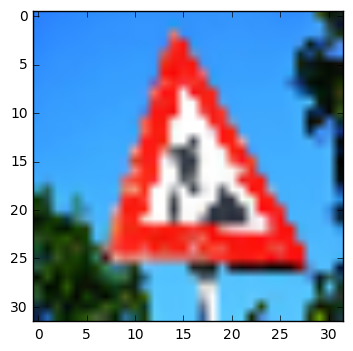

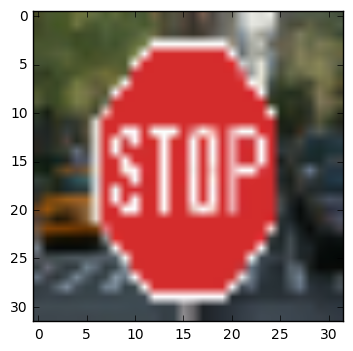

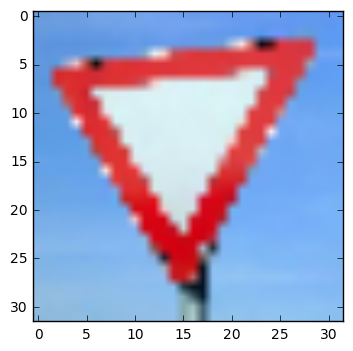

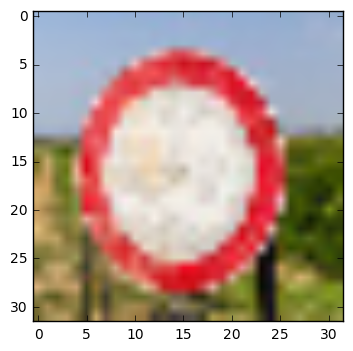

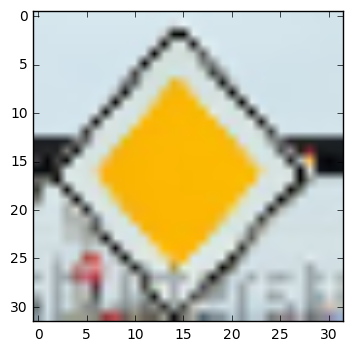

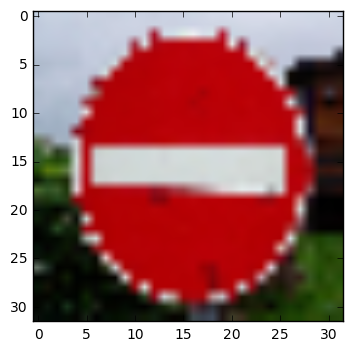

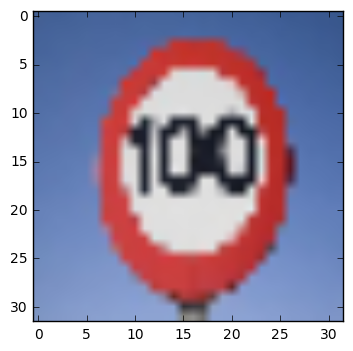

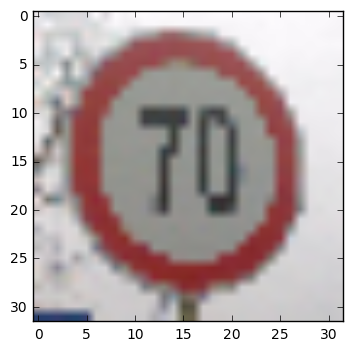

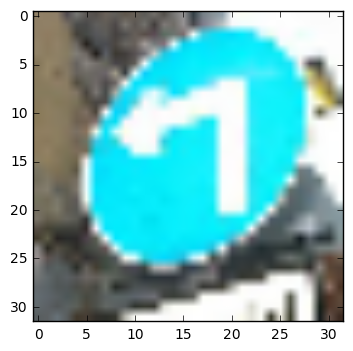

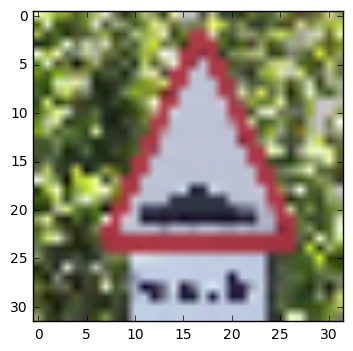

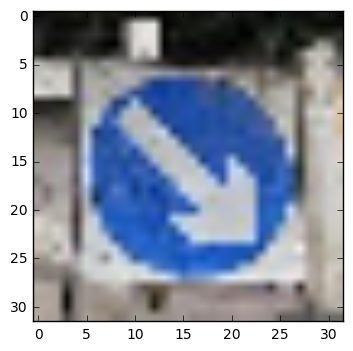

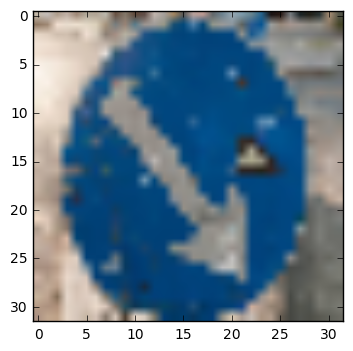

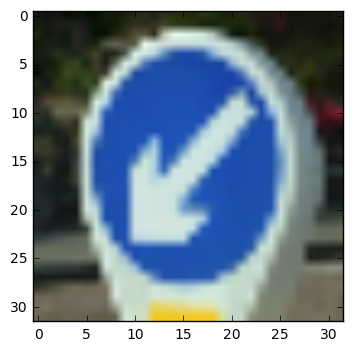

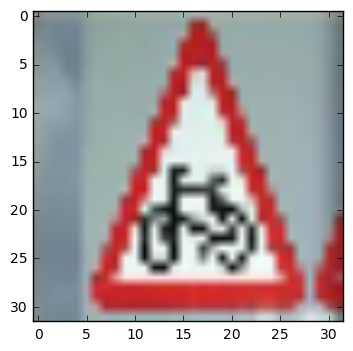

In [19]:
### Load the images and plot them here.
import cv2

EXT_test = []   # extended test set
EXT_images = [] # extended images (10)
EXT_test1 = []  # standardized (-128 and /128) extended test set
names = []
# loading all 10 images
for i in range(1, 15):
    name = "ext-sign"+str(i)+".jpg"
    # store the image in EXT_images
    img = cv2.imread(name)
    # For some rerason I cannot explain, 
    # plt.imread gives an error. The workaround is
    # straighforward with OpenCV (conversion from BGR to RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print("Filename : ", name)
    names.append(name)
    EXT_images.append(img)
    # resize to 32x32x3 and store in EXT_test
    img32x32 = cv2.resize(img, (32, 32))
    # Now add it to EXT_test
    EXT_test.append(img32x32)
    # and finally, standardize the image
    img32x32_std = ( np.float32(img32x32) - 128.0 ) / 128.0
    EXT_test1.append(img32x32_std)

# Now display the images
fig = plt.figure()
for i in range(14):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    plt.imshow(EXT_test[i])
    #a.set_xlabel(names[i], fontsize = 8)

# Now hard-coding ground truth:
Y_gt = [25, 14, 13, 15, 12, 17, 7, 4, 34, 22, 38, 38, 39, 29]

### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
14 images from various (online sources) were chosen.
These images represent traffic signs that follow conventions similar to the ones in the German dataset and the classifier should at least come close to predicting them.

Classification-wise, these images have qualities that could strain the classifier:

#### 1) Different sizes. 

The were all resized to 32x32. This becomes a problem with traffic signs with drawings containingf details such as the "Bicycle crossing". The network is uncertain whether it is "slippery road" or "bicycles crossing". Looking at the resized image, one can see that it can actually fool a human in many occasions, because the bicycle sketch is stretched and can be easily mistaken for something else. 

#### 2) Different perspective angles.

As perspective changes, the shape of the gradients changes accordingly. This problem becomes apparent in the "turn left ahead" sign which is sometimes mistaken for a "turn right" or "turn left". It is my opinion that this sign is distorted beyond the usual standards and the arrow also appears a bit rotated, which is possibly the main reason for which the classifier has "second thoughts". 

#### 3) Noise and smudges over the sign

Some of the images present lines, smudges - noise, minor occlusions over the sign (see the "keep right" sign for instance).

#### 4) The usual problems

Blurring, low contrast.


In [20]:
## Load the output tags in y_tags
import csv
y_tags = []
with open('signnames.csv', 'rt') as f:
    reader = csv.reader(f)
    r = 0    
    for row in reader:
        #print(row)
        if r > 0:        
            y_tags.append(row[1])
        r+=1

In [21]:
prediction = tf.argmax(logits, 1)
softmax_output = tf.nn.softmax(logits)
extractpeaks = tf.nn.top_k(softmax_output, k = 5)
 

def evaluate_input(X_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        Y = sess.run(prediction, feed_dict={x: batch_x})
        Top5s = sess.run(extractpeaks, feed_dict={x: batch_x})
        probs = sess.run(softmax_output, feed_dict = {x: batch_x} )
    return Y, Top5s, probs

Predictions :  [25 14 13 15 12 17  8  4 34 22 38 38 39 29]
Ground truth:  [25, 14, 13, 15, 12, 17, 7, 4, 34, 22, 38, 38, 39, 29]
Success : 92.857 %


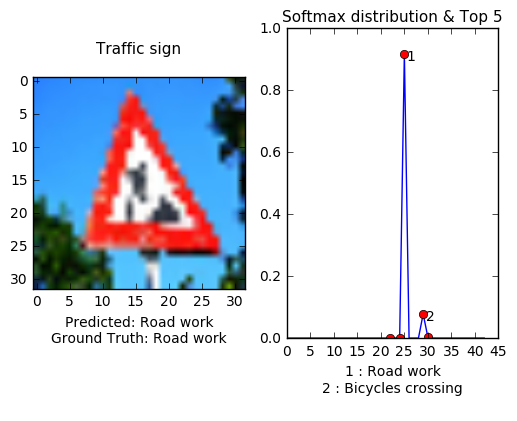

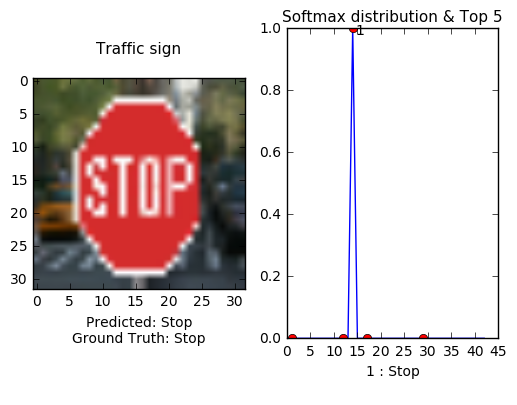

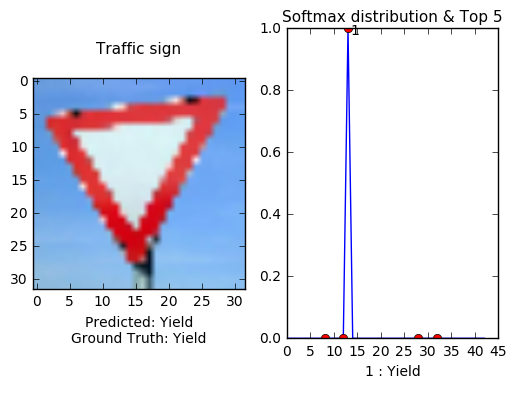

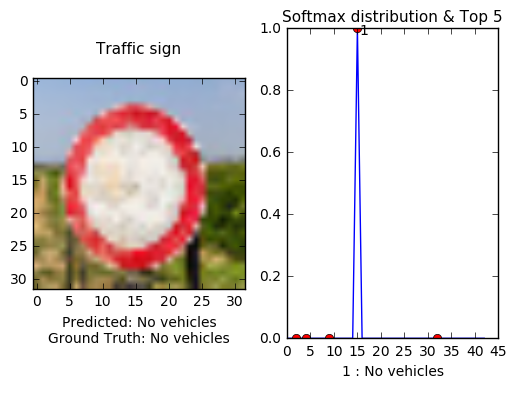

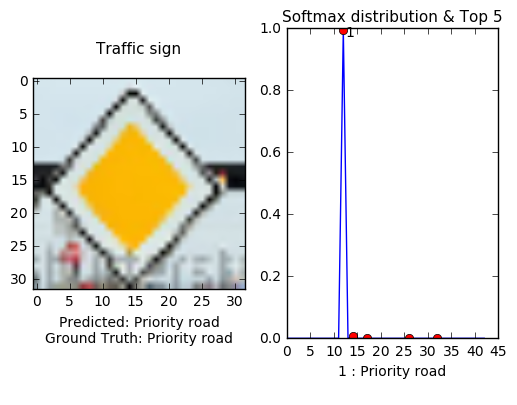

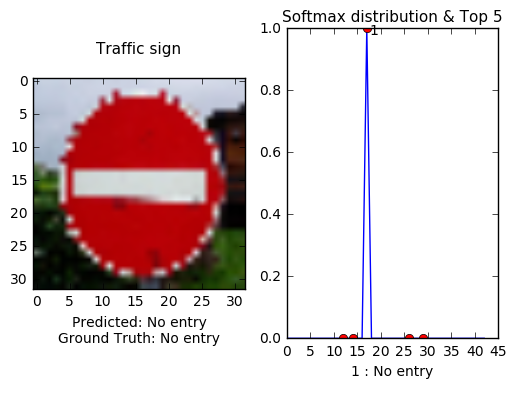

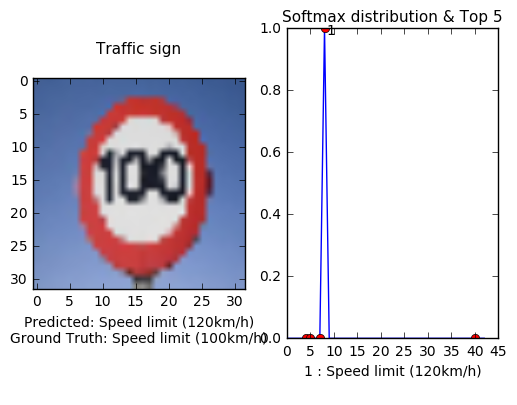

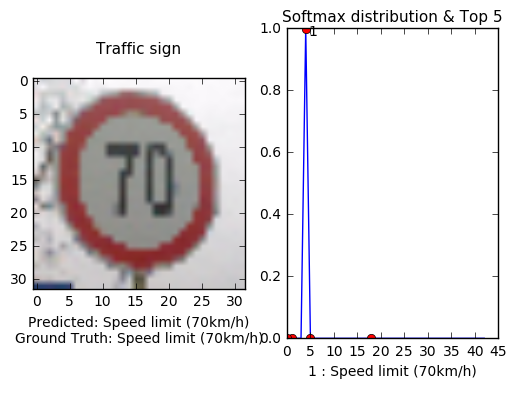

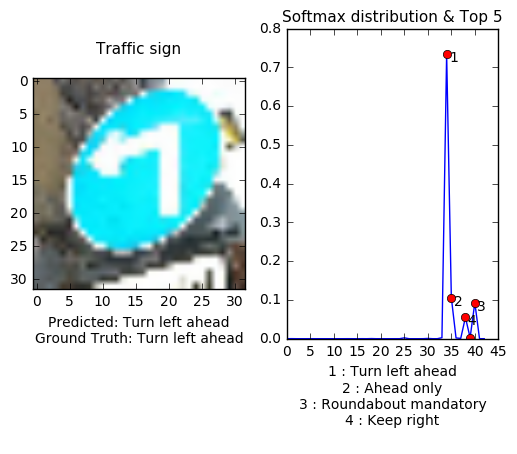

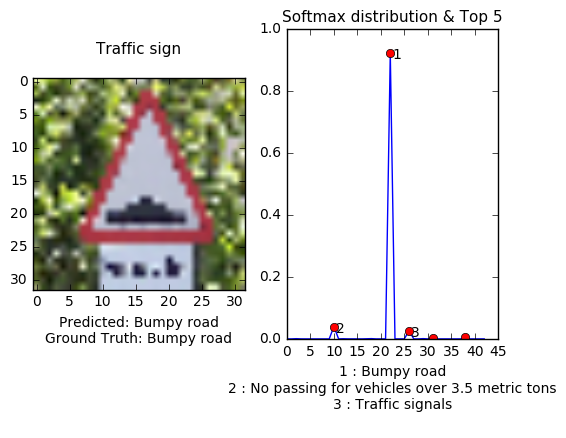

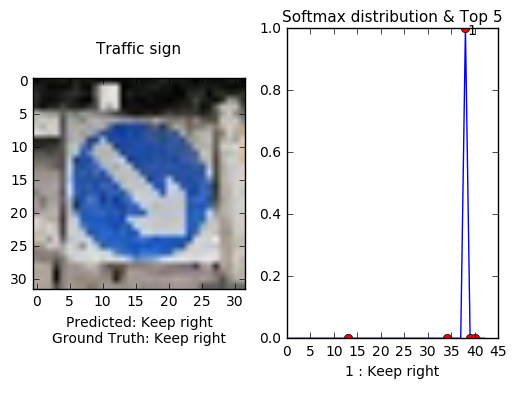

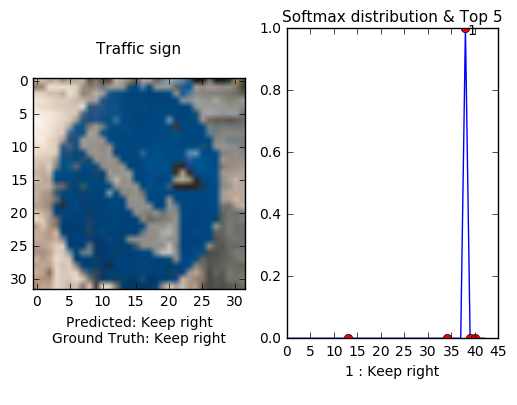

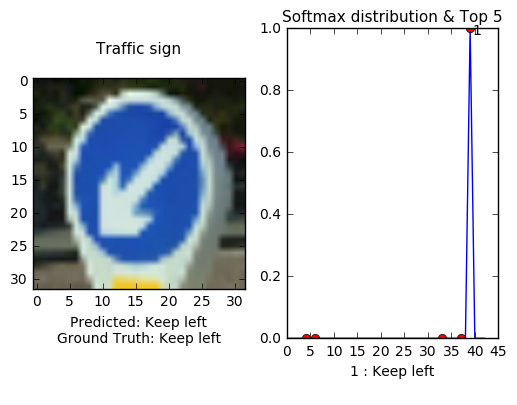

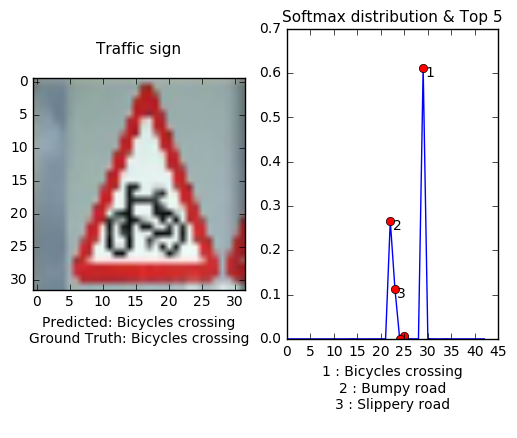

In [22]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
with tf.Session() as session:
    saver.restore(session, tf.train.latest_checkpoint('.'))
    Y, Top5s, probs = evaluate_input(EXT_test1)
    

hits = 0
print("Predictions : ", Y)
print("Ground truth: ", Y_gt)
for i in range(14):
    if (Y[i] == Y_gt[i]):
        hits += 1
print("Success : {:.3f} %".format( hits / 14.0 * 100 ))
#print("Top 5s tags: ", Top5s[1])
#print("Probs of for the first image: ", probs[0])
# Demonstrating classification results now...

for i in range(14):    
    fig = plt.figure(figsize = (6, 4))
    a = fig.add_subplot(1, 2, 1)
    plt.imshow(EXT_test[i])
    a.set_xlabel("Predicted: "+y_tags[Y[i]] + "\n" + "Ground Truth: "+y_tags[Y_gt[i]], fontsize = 10)
    a.set_title("Traffic sign"+"\n", fontsize = 11 )
    
    a = fig.add_subplot(1, 2, 2)
    plt.plot(range(n_classes), probs[i], Top5s[1][i], Top5s[0][i], 'ro')
    
    top_probs_str = ""
    for j in range(5):
        if(Top5s[0][i][j] > 0.01): # don't list very small peaks
            top_probs_str += str(j+1)+" : "+y_tags[Top5s[1][i][j]]+"\n"
            #a.annotate(str(j+1)+" : "+y_tags[Top5s[1][i][j]], (Top5s[1][i][j], Top5s[0][i][j]-0.05) )
            a.annotate(str(j+1), (Top5s[1][i][j] + 0.5, Top5s[0][i][j]-0.02) )
    
    
    a.set_xlabel(top_probs_str, fontsize = 10)
    a.set_title("Softmax distribution & Top 5", fontsize = 11)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The model yields a success score of 93% (13/14 usually, but please note that training is stochastic, so sometimes this can be 100% and sometimes 86%), which is the usual (give or take) performance in the test set (ranges from 93.7% to 94.2% ).

It is worth noting that the network in the majority of cases is very confident for at least 11 out of 14 cases meaning that the softmax distribution is practically a lonely spike (impulse).

The red dots in the softmax plot indicate the top 5 classes (the descriptions are printed under the distribution plot). Please note that if the probability of a class in the top 5 is less than 0.01, than it is omitted from the description list (although the respective red dots will appear in the plot) for display purposes.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

This questions was answered in the plots of question 7. The softmax distribution plot is shown next to the respective traffic sign simage, wherein the top 5 probablities are marked with red dots tagged with numbers from 1 to 5. Below the probability plot, each numeric tag is matched with the corresponding description from the file. I chose not to display the descriptions of outputs with probability less than 0.01 in for display purposes; this way, the focus is on the outputs that are the actual "competitors" for the classifier's output.     

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.